# week 09 PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [112]:
# ! pip install pandas

In [113]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

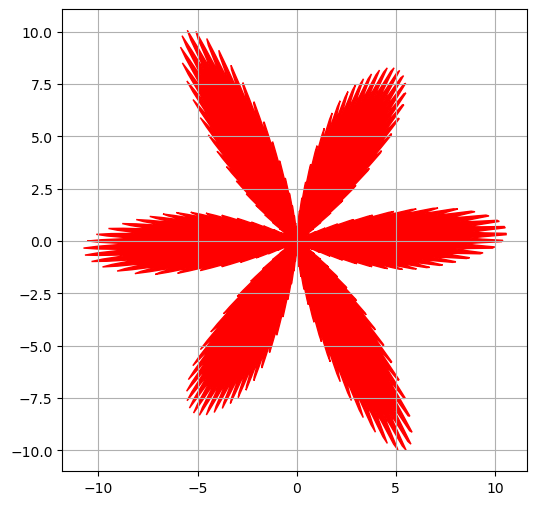

In [114]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = None

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = None
y = None


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color="red")
plt.grid()

### Task 2: Using the Dataloader

In [115]:
from torch import nn
from torch.nn import functional as F

In [116]:
# !wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

In [117]:
# ! pip install sklearn

In [118]:
from notmnist import load_notmnist


X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [119]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [120]:
import cv2

In [222]:
class DatasetMNIST(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data, self.labels = data, labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        
        image = self.data[index]  # (C, H, W)
        image = image.transpose(1, 2, 0)  # (H, W, C)
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)  # [0, 1]
        image = (image.clip(0.0, 1.0) * 255).astype(np.uint8) 
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [173]:
data, labels, _, _ = load_notmnist(path="./notMNIST_small", letters="AB", test_size=0)
full_dataset = DatasetMNIST(data, labels, transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [174]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [175]:
img.max(), img.min()

(255, 0)

In [176]:
img, lab = full_dataset[0]

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [177]:
a = torchvision.transforms.ToTensor()

tensor = a.__call__(img.astype(np.uint8))

In [178]:
type(tensor), tensor.shape, tensor.dtype

(torch.Tensor, torch.Size([1, 28, 28]), torch.float32)

In [179]:
tensor.max(), tensor.min()

(tensor(1.), tensor(0.))

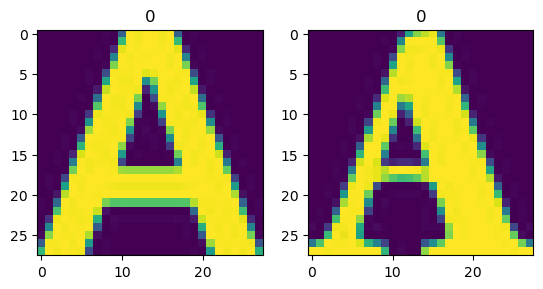

In [180]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

In [181]:
data, labels, _, _ = load_notmnist(path="./notMNIST_small", letters="AB", test_size=0)
full_dataset = DatasetMNIST(data, labels, transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [182]:
img, lab = full_dataset[0]

print(img.shape)
print(type(img))

torch.Size([1, 28, 28])
<class 'torch.Tensor'>


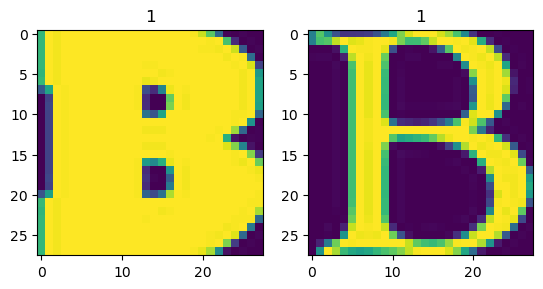

In [185]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [186]:
full_dataset[101][0].shape

torch.Size([1, 28, 28])

In [187]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=0)

We can use dataloader as iterator by using iter() function.

In [188]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [189]:
images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


In [190]:
images.dtype, labels.dtype

(torch.float32, torch.int64)

In [191]:
def custom_collate_fn(batch: list):
    data, target = list(zip(*batch))
    # data[idx] has a shape [C, H, W]
    data = torch.stack(data)  # [B, C, H, W]
    # LongTensor has dtype int64
    target = torch.LongTensor(target)  # [B]
    return data, target

train_loader = DataLoader(full_dataset, collate_fn=custom_collate_fn, batch_size=8, shuffle=True, num_workers=0)

In [192]:
train_iter = iter(train_loader)
images, labels = next(train_iter)

In [193]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images)

grid.shape

torch.Size([3, 32, 242])

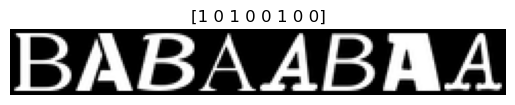

In [201]:
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(str(labels.numpy()))
plt.show()

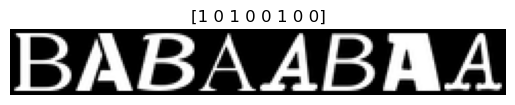

In [206]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(str(labels.numpy()));

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [207]:
class Flatten:
    def __call__(self, pic: torch.Tensor) -> torch.Tensor:
        # pic: tensor of shape (C, H, W)
        # output: tensor of shape (C*H*W)
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [208]:
a = Flatten()

In [209]:
a(img).shape

torch.Size([784])

In [210]:
new_transform = torchvision.transforms.Compose([
#     torchvision.transforms.CenterCrop(),
#     torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor(),
    Flatten(),
])

# Putting all together

In [211]:
import time

from IPython.display import clear_output

In [214]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() \
    else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

device

device(type='mps')

In [215]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [223]:
data, labels, _, _ = load_notmnist(path="./notMNIST_small", test_size=0)
dataset = DatasetMNIST(
    data, labels,
    transform=new_transform,
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [224]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 2996
validation size: 748


In [225]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [226]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [ ]:
loss_func = nn.CrossEntropyLoss()

In [227]:
default_dtype = torch.float32

In [228]:
model = nn.Sequential(
    nn.Linear(28 * 28, 128),
    nn.ReLU(), # nn.Sigmoid(),
    nn.Linear(128, 10),
)
model.to(device, default_dtype)

opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [233]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy_count = 0
        ep_val_accuracy_sum = 0
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = preds.max(-1)[1]
                ep_val_accuracy_sum += (y_pred == y_batch).to(default_dtype).sum().item()
                ep_val_accuracy_count += len(y_batch)

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(ep_val_accuracy_sum / ep_val_accuracy_count)

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [235]:
n_epochs = 30
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.428s
	  training loss: 2.304829
	validation loss: 2.277937
	validation accuracy: 0.164
Epoch 2 of 30 took 0.424s
	  training loss: 2.247004
	validation loss: 2.227949
	validation accuracy: 0.270
Epoch 3 of 30 took 0.422s
	  training loss: 2.195188
	validation loss: 2.176773
	validation accuracy: 0.360
Epoch 4 of 30 took 0.427s
	  training loss: 2.144793
	validation loss: 2.129077
	validation accuracy: 0.477
Epoch 5 of 30 took 0.452s
	  training loss: 2.094517
	validation loss: 2.078481
	validation accuracy: 0.567
Epoch 6 of 30 took 0.443s
	  training loss: 2.042627
	validation loss: 2.025418
	validation accuracy: 0.612
Epoch 7 of 30 took 0.465s
	  training loss: 1.989175
	validation loss: 1.967358
	validation accuracy: 0.648
Epoch 8 of 30 took 0.435s
	  training loss: 1.932493
	validation loss: 1.914901
	validation accuracy: 0.680
Epoch 9 of 30 took 0.428s
	  training loss: 1.874624
	validation loss: 1.852549
	validation accuracy: 0.693
Epoch 10 of 30 took 0.441s
	

In [236]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

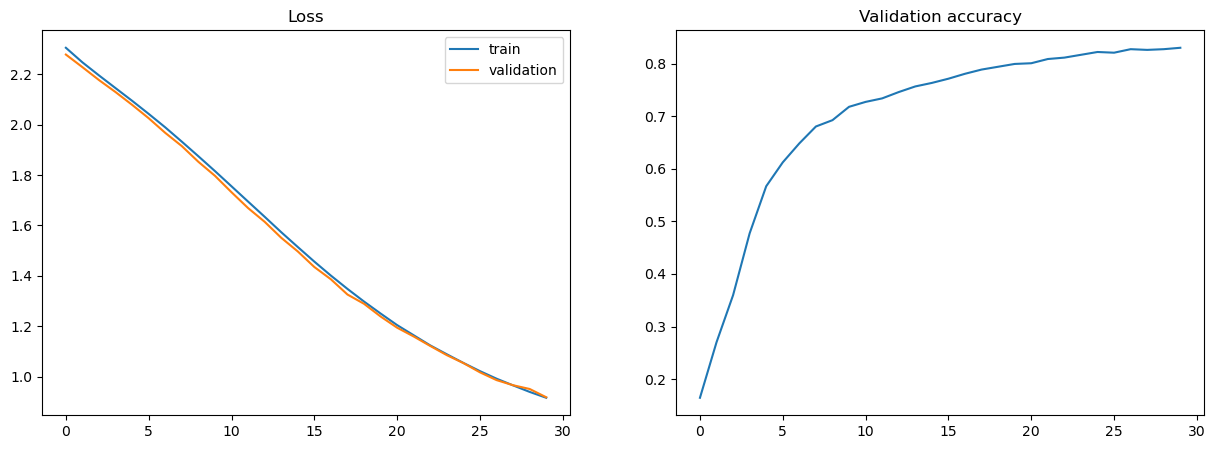

In [237]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Overfit!!!

In [238]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [239]:

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.730s
	  training loss: 0.801091
	validation loss: 0.495873
	validation accuracy: 0.864
Epoch 2 of 30 took 0.812s
	  training loss: 0.406236
	validation loss: 0.411879
	validation accuracy: 0.880
Epoch 3 of 30 took 0.825s
	  training loss: 0.321058
	validation loss: 0.440349
	validation accuracy: 0.866
Epoch 4 of 30 took 0.784s
	  training loss: 0.233519
	validation loss: 0.493267
	validation accuracy: 0.869
Epoch 5 of 30 took 0.766s
	  training loss: 0.196871
	validation loss: 0.367635
	validation accuracy: 0.882
Epoch 6 of 30 took 0.775s
	  training loss: 0.149438
	validation loss: 0.385830
	validation accuracy: 0.881
Epoch 7 of 30 took 0.769s
	  training loss: 0.119281
	validation loss: 0.506445
	validation accuracy: 0.874
Epoch 8 of 30 took 0.759s
	  training loss: 0.103481
	validation loss: 0.448622
	validation accuracy: 0.882
Epoch 9 of 30 took 0.786s
	  training loss: 0.098086
	validation loss: 0.519096
	validation accuracy: 0.878
Epoch 10 of 30 took 0.784s
	

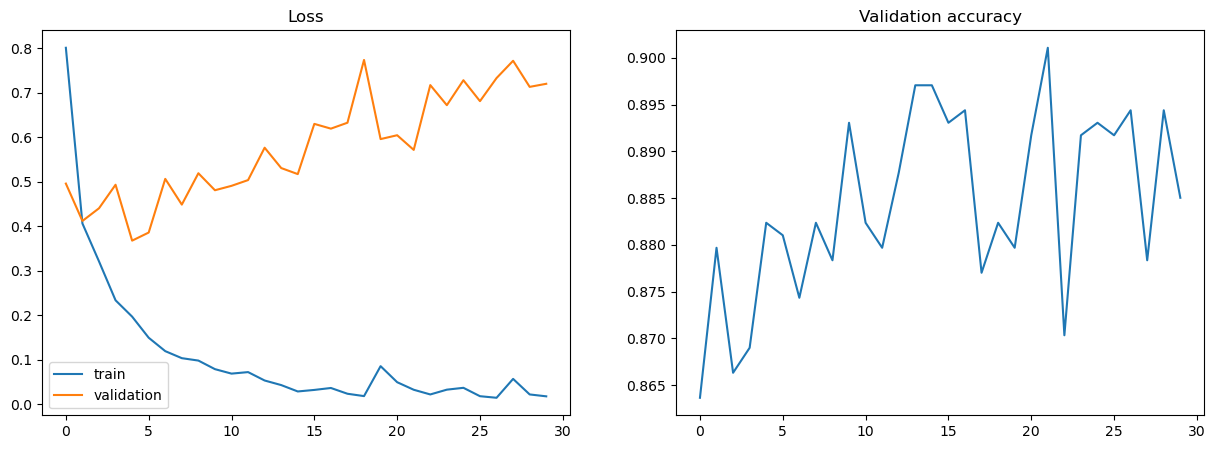

In [240]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [242]:
# !pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [243]:
import torchsummary

In [247]:
torchsummary.summary(model.to("cpu"), (784,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 200]         100,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

Epoch 1 of 30 took 1.116s
	  training loss: 1.225104
	validation loss: 0.556726
	validation accuracy: 0.861
Epoch 2 of 30 took 0.845s
	  training loss: 0.570366
	validation loss: 0.430859
	validation accuracy: 0.880
Epoch 3 of 30 took 0.832s
	  training loss: 0.453259
	validation loss: 0.391201
	validation accuracy: 0.886
Epoch 4 of 30 took 0.834s
	  training loss: 0.396956
	validation loss: 0.389100
	validation accuracy: 0.886
Epoch 5 of 30 took 0.893s
	  training loss: 0.357057
	validation loss: 0.358114
	validation accuracy: 0.888
Epoch 6 of 30 took 0.837s
	  training loss: 0.332914
	validation loss: 0.347640
	validation accuracy: 0.896
Epoch 7 of 30 took 0.847s
	  training loss: 0.321768
	validation loss: 0.348074
	validation accuracy: 0.885
Epoch 8 of 30 took 0.825s
	  training loss: 0.302114
	validation loss: 0.400704
	validation accuracy: 0.877
Epoch 9 of 30 took 0.853s
	  training loss: 0.278242
	validation loss: 0.350242
	validation accuracy: 0.900
Epoch 10 of 30 took 0.894s
	

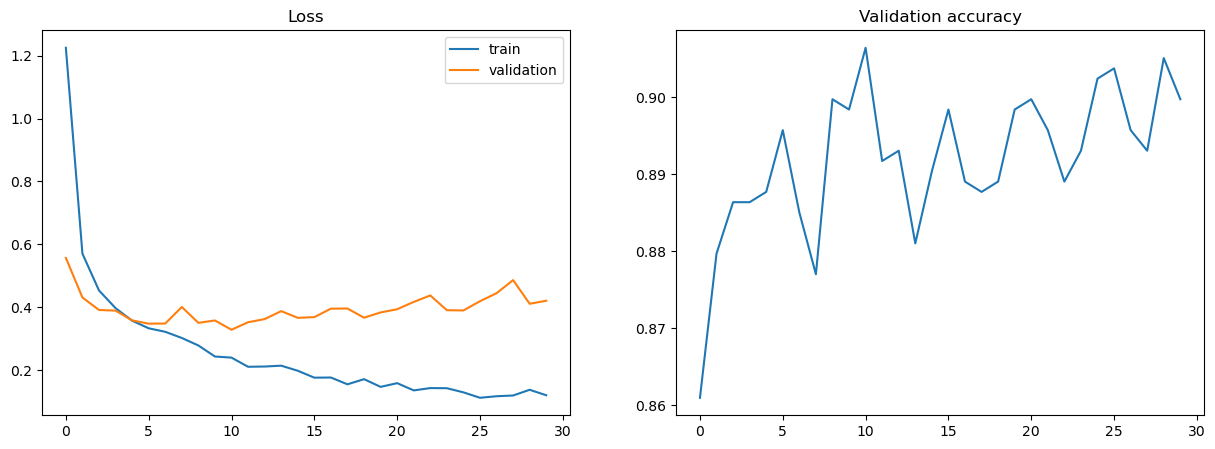

In [253]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 10),
    # nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

Epoch 1 of 30 took 2.421s
	  training loss: 0.970179
	validation loss: 0.487902
	validation accuracy: 0.861
Epoch 2 of 30 took 1.152s
	  training loss: 0.536456
	validation loss: 0.392792
	validation accuracy: 0.874
Epoch 3 of 30 took 1.147s
	  training loss: 0.446578
	validation loss: 0.372796
	validation accuracy: 0.888
Epoch 4 of 30 took 1.176s
	  training loss: 0.386052
	validation loss: 0.364182
	validation accuracy: 0.896
Epoch 5 of 30 took 1.162s
	  training loss: 0.370776
	validation loss: 0.370974
	validation accuracy: 0.882
Epoch 6 of 30 took 1.156s
	  training loss: 0.344307
	validation loss: 0.380227
	validation accuracy: 0.889
Epoch 7 of 30 took 1.167s
	  training loss: 0.306227
	validation loss: 0.366731
	validation accuracy: 0.886
Epoch 8 of 30 took 1.161s
	  training loss: 0.300896
	validation loss: 0.374020
	validation accuracy: 0.888
Epoch 9 of 30 took 1.126s
	  training loss: 0.270565
	validation loss: 0.389421
	validation accuracy: 0.896
Epoch 10 of 30 took 1.132s
	

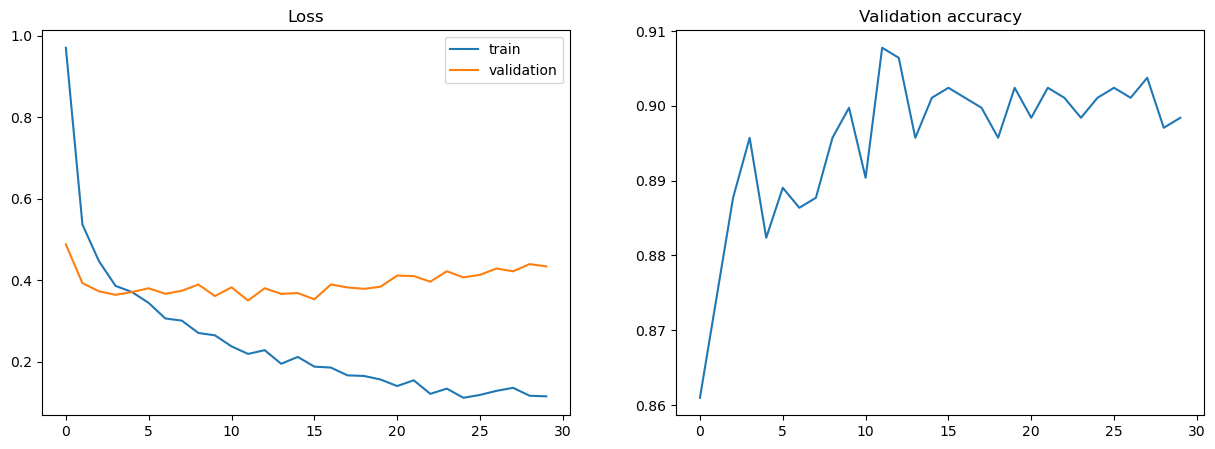

In [254]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 10),
    # nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [256]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print("model saved to %s" % checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print("model loaded from %s" % checkpoint_path)

In [257]:
save_checkpoint("ckpt.pth", model, opt)

model saved to ckpt.pth


In [259]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 10),
    # nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [260]:
loss_fn = nn.CrossEntropyLoss()
ep_val_loss = []
ep_val_accuracy_sum = 0
ep_val_accuracy_count = 0
model.train(False)  # disable dropout / use averages for batch_norm
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)

        # compute predictions
        ep_val_loss.append(loss.item())
        y_pred = preds.max(-1)[1]
        ep_val_accuracy_sum += (y_pred == y_batch).to(default_dtype).sum().item()
        ep_val_accuracy_count += len(y_batch)

print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
print(f"\tvalidation accuracy: {ep_val_accuracy_sum / ep_val_accuracy_count:.3f}")

	validation loss: 2.302511
	validation accuracy: 0.106


In [261]:
load_checkpoint("ckpt.pth", model, opt)

model loaded from ckpt.pth


In [262]:
loss_fn = nn.CrossEntropyLoss()
ep_val_loss = []
ep_val_accuracy_sum = 0
ep_val_accuracy_count = 0
model.train(False)  # disable dropout / use averages for batch_norm
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        # move data to target device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)

        # compute predictions
        ep_val_loss.append(loss.item())
        y_pred = preds.max(-1)[1]
        ep_val_accuracy_sum += (y_pred == y_batch).to(default_dtype).sum().item()
        ep_val_accuracy_count += len(y_batch)

print(f"\tvalidation loss: {np.mean(ep_val_loss):.6f}")
print(f"\tvalidation accuracy: {ep_val_accuracy_sum / ep_val_accuracy_count:.3f}")

	validation loss: 0.446771
	validation accuracy: 0.898


### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)